# Paleontology Machine Learning Project


---

## Explanation 

This project is based on a data base found on https://data.world/bryon/paleobiodb. It is called Paleobilogy Database and is a public database of paleontological data.
This database contains the list of fossiles found on earth with their found locations,descriptions, genuses etc.. 


**What are the main objectives of this project?** 
- study the data attributes to estimate which factors are most important when determining the identity of a given fossil sample.
- test multiple machine learning algorithm to predict the genus of a fossile according to its features.
- compare efficiency/accuracy of those algorithms to understand which algorithm is best fitted for this type of machine learning problem.

---


## Glossary <a id='glossary'></a>
 0) [Processing data](#processing_data)
 1) [KNN with 3 genuses](#processing_data)
 2) [KNN in 3D](#knn3d)
 3) [Logistic regression](#logistic_regression)
 4) [Decision tree](#decision_tree)
 5) [PCA for higher dimensions](#pca)

(you can click on the links to jump directly to each subpart)

---

#### Import libraries

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Import stuff for k-nearest neighbor 
import sklearn.neighbors
import sklearn.linear_model
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
#from mpl_toolkits.basemap import Basemap


#import google.colab
#from google.colab import files
#uploaded = files.upload()

---

## 0) Processing data <a id='processing data'> </a>

In [5]:
data = pd.read_csv('thegigafile.csv')

In [6]:
#Vizualising data 
data

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,lithology1,composition
0,353.8,345.3,Australosutura,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
1,353.8,345.3,Carbonocoryphe,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
2,353.8,345.3,Thigriffides,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
3,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
4,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
...,...,...,...,...,...,...,...,...,...
743654,99.6,93.5,Lepicerus,96.720001,26.360001,105.50,8.29,amber,chitin
743655,468.1,460.9,Eremotoechia,-86.784721,33.311111,-114.63,-8.13,"""limestone""",low Mg calcite
743656,467.3,458.4,Eremotoechia,-84.129166,35.741669,-112.38,-10.30,"""limestone""",low Mg calcite
743657,467.3,458.4,Eremotoechia,-84.125000,35.750000,-112.37,-10.29,"""limestone""",low Mg calcite


In [7]:
print(len(data.columns))

9


---
## 1) K-nearest neighbor (Space/Genus)


The first model we will implement will be a kNN.

#### [Jump back to glossary](#glossary)

### a) Data sampling

In [8]:
#Test here on only three data frame
new_table = data[['lng', 'lat', 'genus']].copy()

In [9]:
new_table

,lng,lat,genus
0,-98.099998,31.000000,Australosutura
1,-98.099998,31.000000,Carbonocoryphe
2,-98.099998,31.000000,Thigriffides
3,-98.099998,31.000000,Pudoproetus
4,-98.099998,31.000000,Pudoproetus
...,...,...,...
743654,96.720001,26.360001,Lepicerus
743655,-86.784721,33.311111,Eremotoechia
743656,-84.129166,35.741669,Eremotoechia
743657,-84.125000,35.750000,Eremotoechia


### b) Using k-nearest neighbor with 3 genuses 

#### i) Look at the most occurences of genuses 

In [8]:
genus_counts = new_table['genus'].value_counts().reset_index()
genus_counts.columns = ['genus', 'count']
genus_counts = genus_counts.sort_values(by='count', ascending=False)

# Print the ranking
print("Ranking of genera with the most occurrences:")
#for index, row in genus_counts.iterrows():
#    print(f"{index+1}. {row['genus']}: {row['count']} occurrences")

Ranking of genera with the most occurrences:


#### ii) create kNN classification on a small data subset 

In [9]:
filtered_table = new_table[new_table['genus'].isin(['Eremotoechia', 'Pudoproetus', 'Carbonocoryphe'])]

In [10]:
filtered_table = filtered_table.sample(frac=1).reset_index(drop=True)
len(filtered_table)

38

In [11]:
#plotting function 
def plot_scatter(color_map, data_set, x_column, y_column, group_column):
    plt.figure(figsize=(10, 6))
    for group, group_data in data_set.groupby(group_column):
        plt.scatter(group_data[x_column], group_data[y_column], label=group, color=color_map.get(group, 'black'))
    
    plt.xlabel(x_column.capitalize())
    plt.ylabel(y_column.capitalize())
    plt.title(f'Scatter Plot of {x_column.capitalize()} vs {y_column.capitalize()}')
    plt.legend()
    plt.show()

In [12]:
#knn -classification function 
def knn_classification(data, features, target, test_size=0.2, n_neighbors=5):
    # Split the data into features (X) and target (y)
    X = data[features]
    y = data[target]
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Initialize the KNN classifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy


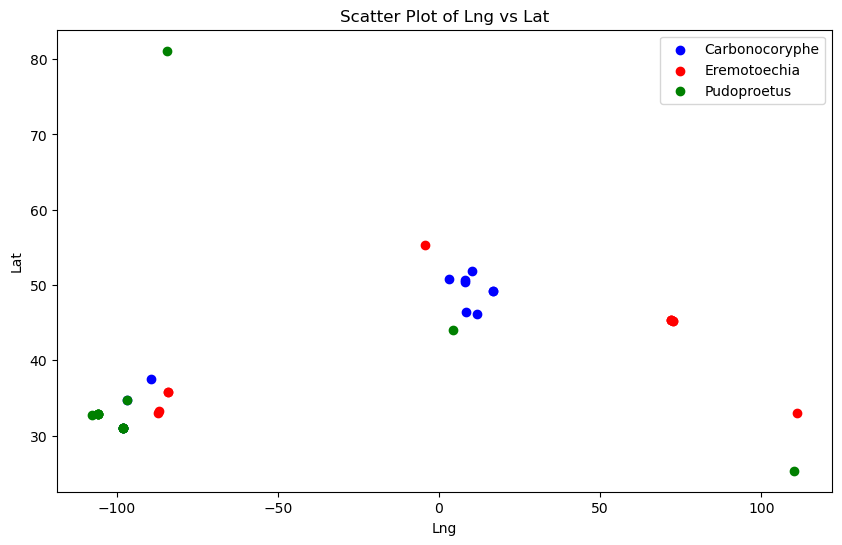

In [13]:
color_map = {
    'Carbonocoryphe': 'blue',
    'Pudoproetus': 'green',
    'Eremotoechia': 'red'
}
plot_scatter(color_map, filtered_table, 'lng', 'lat', 'genus')


##### Decision boundary for k = 3 

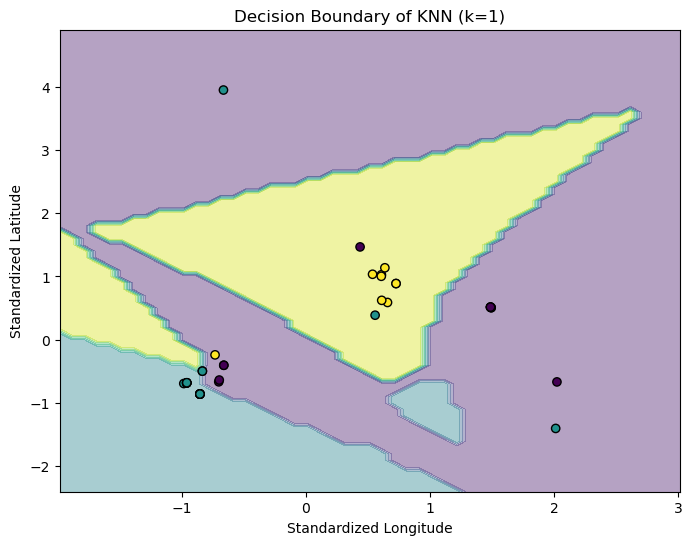

In [14]:
X = filtered_table[['lng', 'lat']]
y = filtered_table['genus']

y = filtered_table['genus'].replace({'Carbonocoryphe': 2,'Pudoproetus': 1, 'Eremotoechia': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=1)')
plt.show()

In [15]:
accuracy = knn_classification(filtered_table, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.625


#### iii) kNN classification on bigger data

In [16]:
filtered_table2 = new_table[new_table['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]

In [17]:
filtered_table2= filtered_table2.sample(frac=1).reset_index(drop=True)# --> shuffle the rows 
filtered_table2

,lng,lat,genus
0,-113.598053,39.228058,Composita
1,-176.576996,-43.959000,Chlamys
2,-104.822800,31.902000,Composita
3,-22.990999,70.832001,Chlamys
4,-87.290558,31.990833,Ostrea
...,...,...,...
5076,-66.050003,-47.133331,Chlamys
5077,99.379997,37.490002,Chlamys
5078,-87.578613,31.546667,Chlamys
5079,12.566667,47.583332,Chlamys


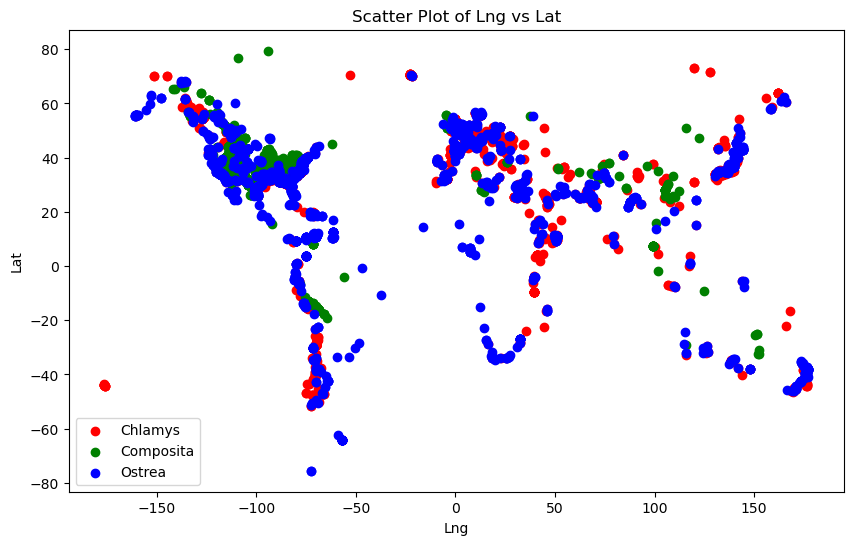

In [18]:
color_map = {
    'Ostrea': 'blue',
    'Composita': 'green',
    'Chlamys': 'red'
}

# Create a scatter plot
plot_scatter(color_map, filtered_table2, 'lng', 'lat', 'genus')


#### iv) Drawing the decision boundary for k =3 

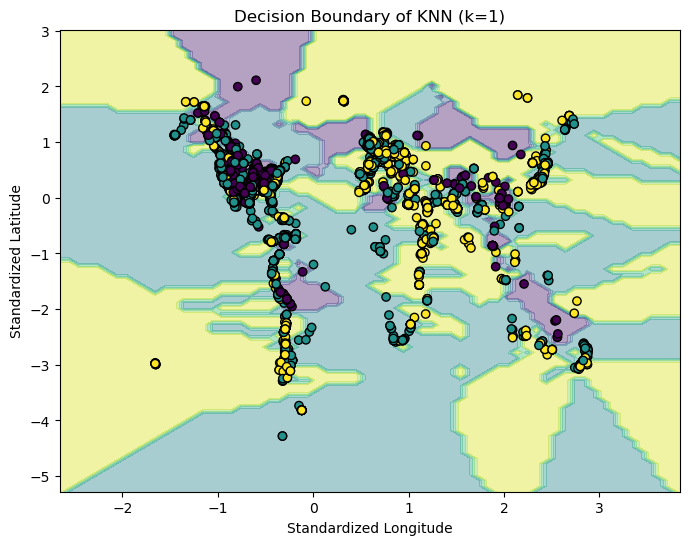

In [19]:
X = filtered_table2[['lng', 'lat']]
y = filtered_table2['genus']

y = filtered_table2['genus'].replace({'Chlamys': 2,'Ostrea': 1, 'Composita': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=1)')
plt.show()

In [20]:
accuracy = knn_classification(filtered_table2, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.8259587020648967


Very good accuracy at around 80% 

However, there are **major problems**  to such approach : 

- we taking the longitude and latitude of species that may have lived millions years away but maybe at the same place --> time has to be taken into account 

- longitude and latitude in 2D is prone to many errors (example : fossile in Alaska and in Kamchatka are close but in terms of longitude and latitude there are in opposite places)

### c) Expanding kNN to more genuses

---
## 2) k nearest neighbor 3D (Space/ Time/ genuses) <a id='knn3d'></a>

#### [Jump back to glossary](#glossary)

### a) Preprocessing

Lets first renormalize the columns. We need to find a way to calculate distance

In [21]:
#defining a new metric for 3D knn using haversine distance and difference in time
from sklearn.metrics.pairwise import haversine_distances
def timespace_metric(X: np.array ,Y: np.array):
    place1=X[:2]
    place2=Y[:2]
    space= haversine_distances([place1],[place2])/np.pi
    time=np.abs(X[-1]-Y[-1])/587.99415
    return (space+3*time)[0][0]

In [22]:
# checking for the max time difference to renormalize
matrix=data.values
mat=(matrix[:, 0]+matrix[:, 1])/2
M=max(mat)
m=min(mat)
M-m

587.99415

In [23]:
#looks good
timespace_metric(np.array([0,0,0]),np.array([np.pi,0,0]))

1.0

In [24]:
#creating the right subdataframe
data3d=data.copy
data3d=data[['lng', 'lat', 'genus']].copy()
data3d['time']=(data['max_ma']+data['min_ma'])/2
data3d = data3d[data3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]
data3d

,lng,lat,genus,time
217,-95.854721,36.123611,Composita,309.85
274,-95.421944,37.185833,Composita,328.90
285,-96.002502,35.937778,Composita,309.85
304,-96.430832,35.123890,Composita,309.85
319,-95.421944,37.185833,Composita,328.90
...,...,...,...,...
742386,-121.123001,37.222000,Ostrea,69.05
742388,-121.113998,37.223000,Ostrea,69.05
742473,-121.211998,37.203999,Ostrea,97.20
742653,-121.094002,37.192001,Ostrea,69.05


### b) Visualizing data

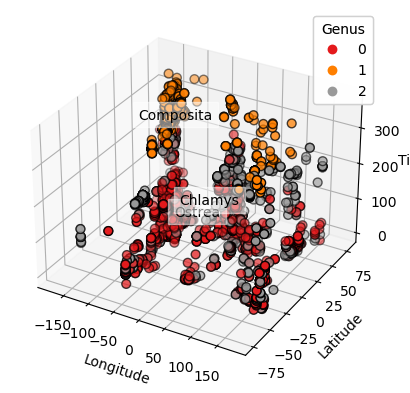

In [25]:
#3D Vizualisation added recently by me --> Oscar :) 

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data3d['lng'], data3d['lat'], data3d['time'], c=data3d['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)


for name, label in [('Ostrea', 0), ('Composita', 1), ('Chlamys', 2)]:
    ax.text3D(data3d[data3d['genus'] == name]['lng'].mean(),
              data3d[data3d['genus'] == name]['lat'].mean(),
              data3d[data3d['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()


In [26]:
def train3dknn(timespaceratio,neighbors=5,test_size=100):
    #timespaceratio is time_importance/space_importance
    def timespace_metric(X: np.array ,Y: np.array):
        place1=X[:2]
        place2=Y[:2]
        space= haversine_distances([place1],[place2])/np.pi
        time=np.abs(X[-1]-Y[-1])/587.99415
        return (space+timespaceratio*time)[0][0]
    
    
    
    total_rows = len(X)
    # Select the indices for training and testing sets
    train_indices_3D = list(range(total_rows - test_size))  # Use all rows except the last 10 for training
    test_indices_3D = list(range(total_rows - test_size, total_rows))  # Use the last 10 rows for testing
    
    # Split the DataFrame into training and testing sets
    x_train_3D = data3d.iloc[train_indices_3D][['lng', 'lat','time']]  # Assuming 'lng' and 'lat' are the features
    y_train_3D = data3d.iloc[train_indices_3D]['genus']
    x_test_3D = data3d.iloc[test_indices_3D][['lng', 'lat','time']]
    y_test_3D = data3d.iloc[test_indices_3D]['genus']
    
    
    #try to use k-nearest neighbor on simple data 
    model3d = sklearn.neighbors.KNeighborsClassifier(n_neighbors=neighbors,metric=timespace_metric)
    model3d.fit(X=x_train_3D, y=y_train_3D)
    
    # Make predictions on the test set
    y_pred_3D = model3d.predict(x_test_3D)
    
    accuracy3D = accuracy_score(y_test_3D, y_pred_3D)
    return accuracy3D




In [27]:
train3dknn(3)

0.77

---
# 3) Logistic regression <a id='logistic_regression'></a>

#### [Jump back to glossary](#glossary)

---
# 4) Decision tree <a id='decision_tree'></a>

This section of the project is dedicated to creating a decision tree to attempt to classify each fossil based on criterions.

#### [Jump back to glossary](#glossary)

### a) Data processing

### b) Decision tree

### c) Visualization and results

---
# 5) PCA ? for higher dimensions <a id='pca'></a> 

#### [Jump back to glossary](#glossary)